'ax.set_xlim(-20,20)\nax.set_ylim(-100,100)\nax.set_zlim(-100,90)'

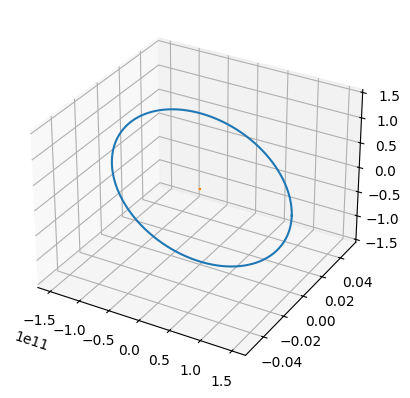

In [ ]:

import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import odeint
import numpy as np

#constants

α=1.496e11
β=29783


m1=5.972e24
m2=1.989e30

G=6.674e-11 
state10=(α,0,0,0,0,β)
state20=(0,0,0,0,0,0)
stateθ=np.concatenate((state10,state20))
t=np.linspace(0,3.154e7,10000)


def a(state,t):
    x1,y1,z1,vx1,vy1,vz1,x2,y2,z2,vx2,vy2,vz2=state
    r12=np.array([x2-x1,y2-y1,z2-z1])
    δ=np.linalg.norm(r12)
    φ=r12/δ
    ψ=G*m1*m2/(δ**2)

    a1=φ*ψ/m1
    a2=φ*(-ψ)/m2


    return vx1,vy1,vz1,a1[0],a1[1],a1[2],vx2,vy2,vz2,a2[0],a2[1],a2[2]

sol=odeint(a,stateθ,t)

fig=plt.figure()
ax=fig.add_subplot(111, projection="3d")

ax.plot(sol.T[0],sol.T[1],sol.T[2])
ax.plot(sol.T[6],sol.T[7],sol.T[8])

